### (BETA) Example 4 - Map of Argo and GLODAP temperature measurements (Poseidon version)

This example will show you how to read and manipulate both Argo and GLODAP temperature data stored in parquet format in WHOI's Poseidon cluster.

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

##### Note on Poseidon

In this example we will access data stored in WHOI's **Poseidon cluster**. Reading data from WHOI's Amazon S3 data lake is slightly different and we refer you to dedicated examples (manipulating the data once loaded into the memory does not change).

NB: to use this example you need to have access to WHOI's VPN or network, **and** to Boom lab's shared storage at `/vortexfs1/share/boom`. The notebook should also be executed from Poseidon.

##### Note on parquet files

The original netCDF Argo files have been converted to parquet format, which provides faster read operations.

There are a couple of ways to read parquet files in Python. We will use pyarrow to load the dataset, so that we can provide a target schema (containing the Argo variable names) and load the data consistently across floats, independently of what variables each float actually has. We will finally convert the dataset to a pandas dataframe for manipulation and plots.
Other ways to read parquet files are by using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), and Dask. Generally speaking, you'll want to use Dask only if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask whenever the data fits in your RAM.

When reading parquet files with pyarrow (or pandas), you can either specificy the file name(s), or the directory containing all the parquet files. In latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

#### Getting started

We start by importing the necessary modules and setting the path and filenames of the parquet files.  For a list of modules that you need to install, you can look at the [README.md file in the repository](https://github.com/boom-lab/nc2parquet).

We also set up the unified schema that pyarrow will need to read the parquet files. This is needed because not all parquet files contain the same variables, depending on what variables are contained in the Argo floats inside each file. This reduces the number of empty fields, and in turn the memory usage during the conversion of the Argo mirror to the parquet format. If we didn't provide the unified schema, pyarrow would not read all the data.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from pprint import pprint

# Paths on Poseidon cluster
argo_dir = '/vortexfs1/share/boom/data/nc2pqt_test/pqt/data/'
# Setting up parquet schema
schemas = []
argo_files = glob.glob(argo_dir + '*.parquet')
for parquet_file in argo_files:
    dataset = pq.ParquetDataset(parquet_file)
    schemas.append(dataset.schema)
unified_schema = pa.unify_schemas(schemas, promote_options="permissive")

glodap_name = 'GLODAPv2.2023_Merged_Master_File.parquet'
glodap_dir = '/vortexfs1/share/boom/data/nc2pqt_test/GLODAP/pqt/'
glodap_file = glodap_dir + glodap_name

lat0 = 34
lat1 = 60
lon0 = -78
lon1 = -45

We now want to set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -78$^\circ$ and -45$^\circ$).

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention.

In [2]:
argo_ds = pq.ParquetDataset(argo_dir, schema=unified_schema)
argo_schema = argo_ds.schema
pprint(sorted(argo_schema.names))

['BBP470',
 'BBP470_ADJUSTED',
 'BBP470_ADJUSTED_ERROR',
 'BBP470_ADJUSTED_QC',
 'BBP470_QC',
 'BBP470_dPRES',
 'BBP532',
 'BBP532_ADJUSTED',
 'BBP532_ADJUSTED_ERROR',
 'BBP532_ADJUSTED_QC',
 'BBP532_QC',
 'BBP532_dPRES',
 'BBP700',
 'BBP700_ADJUSTED',
 'BBP700_ADJUSTED_ERROR',
 'BBP700_ADJUSTED_QC',
 'BBP700_QC',
 'BBP700_dPRES',
 'BISULFIDE',
 'BISULFIDE_ADJUSTED',
 'BISULFIDE_ADJUSTED_ERROR',
 'BISULFIDE_ADJUSTED_QC',
 'BISULFIDE_QC',
 'BISULFIDE_dPRES',
 'CDOM',
 'CDOM_ADJUSTED',
 'CDOM_ADJUSTED_ERROR',
 'CDOM_ADJUSTED_QC',
 'CDOM_QC',
 'CDOM_dPRES',
 'CHLA',
 'CHLA_ADJUSTED',
 'CHLA_ADJUSTED_ERROR',
 'CHLA_ADJUSTED_QC',
 'CHLA_QC',
 'CHLA_dPRES',
 'CP660',
 'CP660_ADJUSTED',
 'CP660_ADJUSTED_ERROR',
 'CP660_ADJUSTED_QC',
 'CP660_QC',
 'CP660_dPRES',
 'CYCLE_NUMBER',
 'DOWNWELLING_PAR',
 'DOWNWELLING_PAR_ADJUSTED',
 'DOWNWELLING_PAR_ADJUSTED_ERROR',
 'DOWNWELLING_PAR_ADJUSTED_QC',
 'DOWNWELLING_PAR_QC',
 'DOWNWELLING_PAR_dPRES',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE380_ADJUSTED'

In [3]:
glodap_ds = pq.ParquetDataset(glodap_file)
glodap_schema = glodap_ds.schema
pprint(sorted(glodap_schema.names))

['G2aou',
 'G2aouf',
 'G2bottle',
 'G2bottomdepth',
 'G2c13',
 'G2c13f',
 'G2c13qc',
 'G2c14',
 'G2c14err',
 'G2c14f',
 'G2cast',
 'G2ccl4',
 'G2ccl4f',
 'G2ccl4qc',
 'G2cfc11',
 'G2cfc113',
 'G2cfc113f',
 'G2cfc113qc',
 'G2cfc11f',
 'G2cfc11qc',
 'G2cfc12',
 'G2cfc12f',
 'G2cfc12qc',
 'G2chla',
 'G2chlaf',
 'G2cruise',
 'G2day',
 'G2doc',
 'G2docf',
 'G2doi',
 'G2don',
 'G2donf',
 'G2expocode',
 'G2fco2',
 'G2fco2f',
 'G2fco2temp',
 'G2gamma',
 'G2h3',
 'G2h3err',
 'G2h3f',
 'G2he',
 'G2he3',
 'G2he3err',
 'G2he3f',
 'G2heerr',
 'G2hef',
 'G2hour',
 'G2maxsampdepth',
 'G2minute',
 'G2month',
 'G2neon',
 'G2neonerr',
 'G2neonf',
 'G2nitrate',
 'G2nitratef',
 'G2nitrateqc',
 'G2nitrite',
 'G2nitritef',
 'G2o18',
 'G2o18f',
 'G2oxygen',
 'G2oxygenf',
 'G2oxygenqc',
 'G2pccl4',
 'G2pcfc11',
 'G2pcfc113',
 'G2pcfc12',
 'G2phosphate',
 'G2phosphatef',
 'G2phosphateqc',
 'G2phts25p0',
 'G2phts25p0f',
 'G2phtsinsitutp',
 'G2phtsinsitutpf',
 'G2phtsqc',
 'G2pressure',
 'G2psf6',
 'G2region',
 

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`,

To get a pandas dataframe, we need first to create a parquet dataset that pyarrow can read with `ParquetDataset()`, then we read it into a pandas dataframe with `read().to_pandas()` methods of the dataset. The filters are applied when `ParquetDataset()` is called.

**NB:** The following operation still fetches a large amount of data (~4.8 GB), so you can skip executing it if your machine does not have enough memory and/or your internet connection isn't great.

You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

Let's call again the same function, but we time its execution now:

It should have taken a total wall time of 8 to 9 seconds. 

We now want to compare this with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception (if it doesn't, let me know!). This is likely due to ERDAP's servers timing out after 1 min (as the wall time consistently measures).

We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data is faster.

Now let's narrow the filters in the time and depth -- let's say we we want to select the data for the past three months and measured between 0 and 50 db.

It now took between 5-6 seconds for our Argo mirror, and 2 to 3 seconds using Argo ERDDAP's servers. These can be faster when we need to access a contained amount of data.

#### Map

As in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates). We do this through the variable `columns` of `read_parquet()`. We also adjust the filter to consider only data labeled with QC=1.

In [4]:
%%time
ref_var = 'TEMP_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED"]
filter_coords_pres = [("LATITUDE",">",lat0), ("LATITUDE","<",lat1),
                           ("LONGITUDE",">",lon0), ("LONGITUDE","<",lon1),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30)]
argo_ds = pq.ParquetDataset(argo_dir, schema=unified_schema, filters=filter_coords_pres)
argo_df = argo_ds.read(columns=cols).to_pandas()
glodap_ds = pq.ParquetDataset(glodap_file, filters=filter_coords_pres)
glodap_df = glodap_ds.read(columns=cols).to_pandas()

CPU times: user 7.63 s, sys: 2.64 s, total: 10.3 s
Wall time: 3.47 s


In [5]:
argo_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,4.163000,58.349146,-45.185610,0.200000
1,4.163667,58.349146,-45.185610,0.800000
2,4.164000,58.349146,-45.185610,1.100000
3,4.165000,58.349146,-45.185610,2.100000
4,4.163750,58.349146,-45.185610,2.600000
...,...,...,...,...
484991,3.119000,43.474998,-57.547001,8.400000
484992,3.122000,43.474998,-57.547001,18.100000
484993,3.124000,43.474998,-57.547001,28.100000
484994,3.125000,43.474998,-57.547001,38.299999


In [6]:
glodap_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,10.6670,44.1280,-62.3210,5.0
1,10.5600,44.0580,-62.0840,5.0
2,10.8320,44.0320,-61.9550,5.0
3,11.1610,43.9720,-61.7080,5.0
4,11.2010,43.9280,-61.5650,5.0
...,...,...,...,...
14632,15.9843,39.8961,-69.9298,25.0
14633,13.9620,39.8961,-69.9298,50.0
14634,10.5726,40.0107,-70.0066,5.0
14635,13.9182,40.0107,-70.0066,25.0


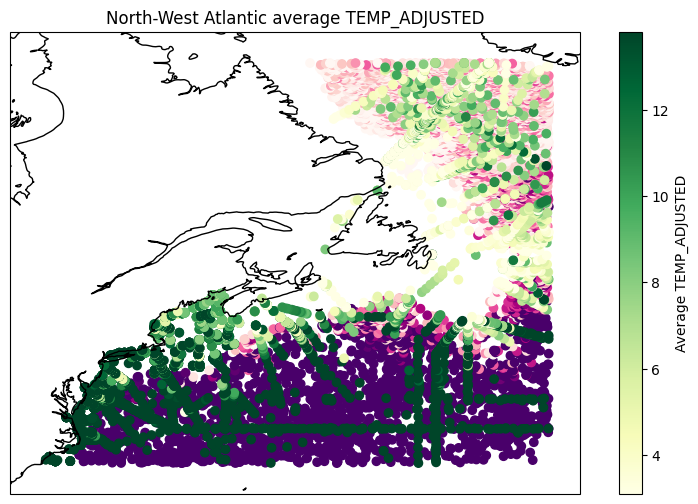

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED'
argo_grouped = argo_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

glodap_grouped = glodap_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = argo_df[ref_var].quantile(q=0.1)
cbar_max = argo_df[ref_var].quantile(q=0.9)
plt.scatter(argo_grouped['LONGITUDE'], argo_grouped['LATITUDE'], c=argo_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='RdPu', transform=ccrs.PlateCarree())
plt.scatter(glodap_grouped['LONGITUDE'], glodap_grouped['LATITUDE'], c=glodap_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='YlGn', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([lon0-2, lon1+2])
plt.ylim([lat0-2, lat1+2])
plt.show()

In [8]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from pprint import pprint

# Paths on Poseidon cluster
argo_dir = '/vortexfs1/share/boom/data/nc2pqt_test/pqt/data/'
argo_files = glob.glob(argo_dir + '*.parquet')

glodap_name = 'GLODAPv2.2023_Merged_Master_File.parquet'
glodap_dir = '/vortexfs1/share/boom/data/nc2pqt_test/GLODAP/pqt/'
glodap_file = glodap_dir + glodap_name

pqt_files = argo_files
pqt_files.append(glodap_file)

# Setting up parquet schema
schemas = []
for parquet_file in pqt_files:
    dataset = pq.ParquetDataset(parquet_file)
    schemas.append(dataset.schema)
combined_schema = pa.unify_schemas(schemas, promote_options="permissive")

In [9]:
%%time
combined_ds = pq.ParquetDataset(pqt_files, schema=combined_schema, filters=filter_coords_pres)
combined_df = combined_ds.read(columns=cols).to_pandas()

CPU times: user 8.38 s, sys: 2.89 s, total: 11.3 s
Wall time: 3.46 s


In [10]:
combined_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,4.163000,58.349146,-45.18561,0.2
1,4.163667,58.349146,-45.18561,0.8
2,4.164000,58.349146,-45.18561,1.1
3,4.165000,58.349146,-45.18561,2.1
4,4.163750,58.349146,-45.18561,2.6
...,...,...,...,...
499628,15.984300,39.896100,-69.92980,25.0
499629,13.962000,39.896100,-69.92980,50.0
499630,10.572600,40.010700,-70.00660,5.0
499631,13.918200,40.010700,-70.00660,25.0


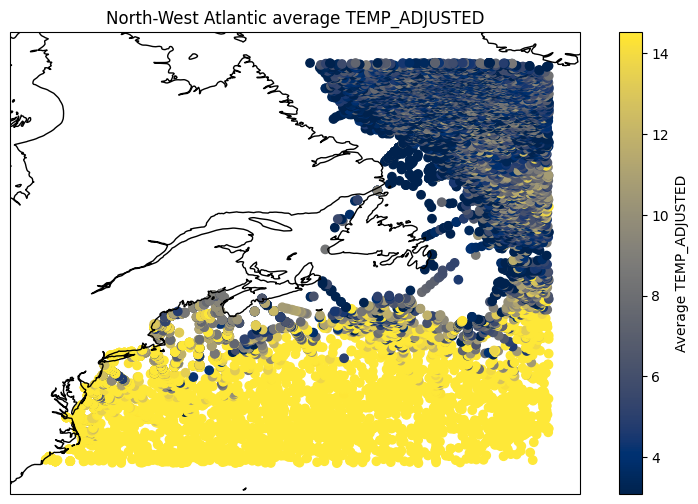

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED'
combined_grouped = combined_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = combined_df[ref_var].quantile(q=0.1)
cbar_max = combined_df[ref_var].quantile(q=0.9)
plt.scatter(combined_grouped['LONGITUDE'], combined_grouped['LATITUDE'], c=combined_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([lon0-2, lon1+2])
plt.ylim([lat0-2, lat1+2])
plt.show()

#### Exercise

Try and access some other metadata, for example:
* filtering by different time periods;
* mapping a different parameter;
* restraining the quality of the data further by imposing PRES_ADJUSTED_ERROR smaller than 20db;
* performing reads/manipulations that you would need to perform your tasks.

If you encounter any issues, please [reach out](enrico.milanese@whoi.edu)!